In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Graph and data storage
graph = nx.DiGraph()
edge_types = {}           # (u, v) -> 'hold' / 'request'
processes = {}            # pid -> {'holds': R, 'requests': R}
process_priority = {}     # pid -> priority
resources = set()

# --- Add Process ---
def add_process(pid, held_resource, requested_resource, priority):
    processes[pid] = {'holds': held_resource, 'requests': requested_resource}
    process_priority[pid] = priority
    resources.update([held_resource, requested_resource])

    # Add edges and classify them
    graph.add_edge(held_resource, pid)
    edge_types[(held_resource, pid)] = 'hold'

    graph.add_edge(pid, requested_resource)
    edge_types[(pid, requested_resource)] = 'request'

    display(Markdown(f"✅ Process `{pid}` added: holds `{held_resource}`, requests `{requested_resource}`, priority `{priority}`"))

# --- Show Graph ---
# --- Show Graph ---
def show_graph(highlight_cycle=[]):
    pos = nx.spring_layout(graph, seed=42)  # ✅ Add seed here for consistent layout

    # Node color logic
    node_colors = []
    for node in graph.nodes:
        if node in highlight_cycle:
            node_colors.append('red')
        elif node.startswith('R'):
            node_colors.append('skyblue')
        else:
            node_colors.append('lightgreen')

    # Classify edges
    hold_edges = [e for e, t in edge_types.items() if t == 'hold']
    request_edges = [e for e, t in edge_types.items() if t == 'request']

    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=1500)
    nx.draw_networkx_labels(graph, pos)
    nx.draw_networkx_edges(graph, pos, edgelist=hold_edges, edge_color='green', arrows=True)
    nx.draw_networkx_edges(graph, pos, edgelist=request_edges, edge_color='orange', arrows=True, style='dashed')

    # Legend
    green_patch = plt.Line2D([0], [0], color='green', lw=2, label='HOLD (resource → process)')
    orange_patch = plt.Line2D([0], [0], color='orange', lw=2, linestyle='--', label='REQUEST (process → resource)')
    plt.legend(handles=[green_patch, orange_patch])
    plt.title("Resource Allocation Graph")
    plt.axis('off')
    plt.show()

# --- Deadlock Detection (DFS) ---
def detect_deadlock():
    visited = set()
    rec_stack = set()
    cycle_path = []

    def dfs(node, path):
        visited.add(node)
        rec_stack.add(node)
        path.append(node)

        for neighbor in graph.successors(node):
            if neighbor not in visited:
                if dfs(neighbor, path):
                    return True
            elif neighbor in rec_stack:
                cycle_start_index = path.index(neighbor)
                cycle_path.extend(path[cycle_start_index:])
                return True

        rec_stack.remove(node)
        path.pop()
        return False

    for node in graph.nodes:
        if node not in visited:
            if dfs(node, []):
                display(Markdown(f"🚨 **Deadlock Detected** involving: {', '.join(set(cycle_path))}"))
                show_graph(highlight_cycle=cycle_path)
                return set(cycle_path)

    display(Markdown("✅ **No Deadlock Detected**"))
    show_graph()
    return set()

# --- Release Resource ---
def release_resource(pid):
    if pid in processes:
        held = processes[pid]['holds']
        req = processes[pid]['requests']

        if (held, pid) in graph.edges:
            graph.remove_edge(held, pid)
            edge_types.pop((held, pid), None)

        if (pid, req) in graph.edges:
            graph.remove_edge(pid, req)
            edge_types.pop((pid, req), None)

        del processes[pid]
        del process_priority[pid]

        display(Markdown(f"🔓 Process `{pid}` terminated and resources released."))
    else:
        display(Markdown(f"❌ Process `{pid}` not found."))

# --- Resolve Deadlock ---
def resolve_deadlock():
    deadlock_nodes = detect_deadlock()
    deadlocked_procs = [p for p in deadlock_nodes if p in processes]

    if not deadlocked_procs:
        return

    least_priority_proc = min(deadlocked_procs, key=lambda p: process_priority[p])
    display(Markdown(f"💡 Suggestion: Terminate process `{least_priority_proc}` with lowest priority `{process_priority[least_priority_proc]}`"))
    release_resource(least_priority_proc)

    display(Markdown("🔁 Rechecking for deadlock..."))
    detect_deadlock()

# --- Debug ---
def debug_graph_state():
    print("📌 All Nodes in Graph:", list(graph.nodes))
    print("📌 All Edges in Graph:", list(graph.edges))

    hold_edges = [e for e, t in edge_types.items() if t == 'hold']
    request_edges = [e for e, t in edge_types.items() if t == 'request']
    known_edges = set(hold_edges + request_edges)
    unknown_edges = [e for e in graph.edges if e not in known_edges]

    print("\n✅ HOLD Edges (green):", hold_edges)
    print("🟠 REQUEST Edges (orange):", request_edges)

    if unknown_edges:
        print("⚠️ Unknown Edges (not in edge_types):", unknown_edges)
    else:
        print("✅ No unexpected edges found.")

    print("\n📊 Processes:")
    for p in processes:
        print(f"  {p}: holds {processes[p]['holds']} → requests {processes[p]['requests']} | priority = {process_priority[p]}")


In [2]:
def menu():
    while True:
        print("\nChoose an action:")
        print("1. Detect Deadlock")
        print("2. Resolve Deadlock (terminate least priority)")
        print("3. Show Resource Allocation Graph")
        print("4. Add a new Process")
        print("5. Release a Process")
        print("6. Exit")

        choice = input("Enter your choice (1-6): ")

        if choice == '1':
            detect_deadlock()
        elif choice == '2':
            resolve_deadlock()
        elif choice == '3':
            show_graph()
        elif choice == '4':
            pid = input("Enter new process ID (e.g., D): ")
            held = input(f"Process {pid} holds which resource? ")
            req = input(f"Process {pid} requests which resource? ")
            prio = int(input(f"Enter priority for process {pid}: "))
            add_process(pid, held, req, prio)
        elif choice == '5':
            pid = input("Enter process ID to release: ")
            release_resource(pid)
        elif choice == '6':
            print("Exiting simulation.")
            break
        else:
            print("Invalid choice. Please try again.")




Enter number of processes: 2
Enter number of resources: 2
Process A holds which resource? (e.g., R1): R1
Process A requests which resource? (e.g., R2): R2
Enter priority for process A (lower is higher priority): 1


✅ Process `A` added: holds `R1`, requests `R2`, priority `1`

Process B holds which resource? (e.g., R1): R2
Process B requests which resource? (e.g., R2): R1
Enter priority for process B (lower is higher priority): 2


✅ Process `B` added: holds `R2`, requests `R1`, priority `2`


Choose an action:
1. Detect Deadlock
2. Resolve Deadlock (terminate least priority)
3. Show Resource Allocation Graph
4. Add a new Process
5. Release a Process
6. Exit
Enter your choice (1-6): 1


🚨 **Deadlock Detected** involving: R2, B, A, R1

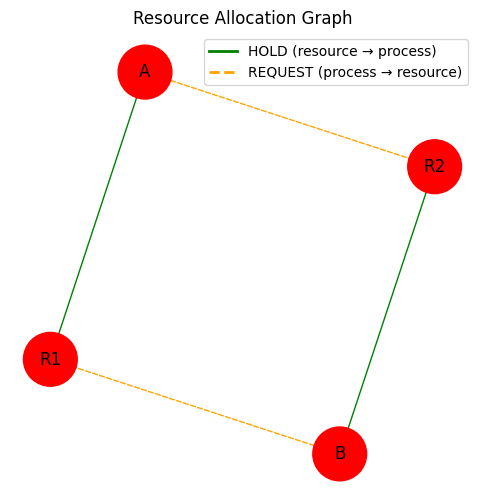


Choose an action:
1. Detect Deadlock
2. Resolve Deadlock (terminate least priority)
3. Show Resource Allocation Graph
4. Add a new Process
5. Release a Process
6. Exit
Enter your choice (1-6): 2


🚨 **Deadlock Detected** involving: R2, B, A, R1

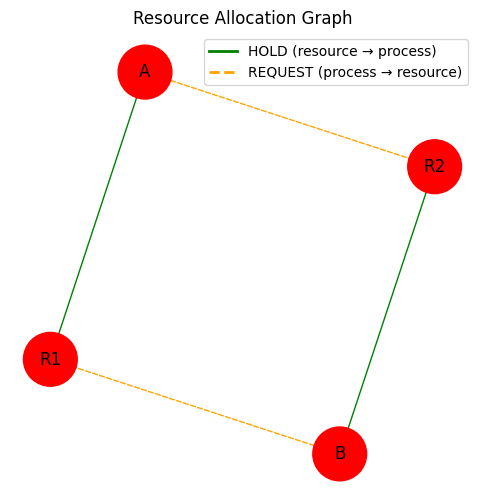

💡 Suggestion: Terminate process `A` with lowest priority `1`

🔓 Process `A` terminated and resources released.

🔁 Rechecking for deadlock...

✅ **No Deadlock Detected**

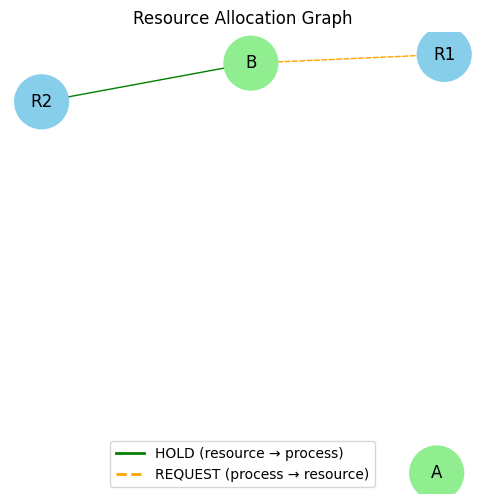


Choose an action:
1. Detect Deadlock
2. Resolve Deadlock (terminate least priority)
3. Show Resource Allocation Graph
4. Add a new Process
5. Release a Process
6. Exit
Enter your choice (1-6): 3


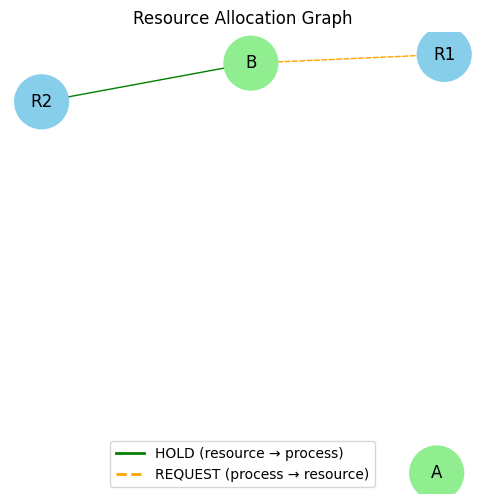


Choose an action:
1. Detect Deadlock
2. Resolve Deadlock (terminate least priority)
3. Show Resource Allocation Graph
4. Add a new Process
5. Release a Process
6. Exit


In [ ]:
# Step 1: Initial user input
n = int(input("Enter number of processes: "))
m = int(input("Enter number of resources: "))

for i in range(n):
    pid = chr(ord('A') + i)
    held = input(f"Process {pid} holds which resource? (e.g., R1): ")
    req = input(f"Process {pid} requests which resource? (e.g., R2): ")
    prio = int(input(f"Enter priority for process {pid} (lower is higher priority): "))
    add_process(pid, held, req, prio)

# ✅ Step 2: Start interactive menu

menu()

